# APS360 Project

1. Load and split data for training, validation and testing
2. Creating Generator
3. Creating Discriminator
4. Training



## Part A. Data Loading

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
import shutil
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


### 0. Helper Functions ###

In [3]:
###############################################################################
# Data Loading
import os
import random
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler

class ImageBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


class AnimeHumanImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Since there are no labels, we can return a dummy label (0)
    

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    """
    Creates a subset of the original dataset.
    
    Args:
        original_dir (str): Path to the original dataset directory.
        subset_dir (str): Path to the subset dataset directory.
        subset_size (int): Number of images to include in the subset.
    """
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    # Get all image paths
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    # Shuffle and select a subset
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    # Copy images to the subset directory
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(224, 224), subset_size=None):
    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Use a subset of the dataset if specified
    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler, num_workers=1)
        return loader

    # Function to split dataset indices
    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)  # Setting a seed for reproducibility
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    # Get split indices for the dataset
    train_indices, val_indices, test_indices = split_indices(dataset)

    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, path_prefix):
    np.savetxt(f"{path_prefix}_train_loss_anime.csv", train_loss_anime_history)
    np.savetxt(f"{path_prefix}_train_loss_human.csv", train_loss_human_history)
    np.savetxt(f"{path_prefix}_val_loss_anime.csv", val_loss_anime_history)
    np.savetxt(f"{path_prefix}_val_loss_human.csv", val_loss_human_history)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

### 1.1 Load Data ###

In [4]:
# # Use smaller subsets for quick testing
# create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetA_10k', 'data/subset_dataSetA', subset_size=100)
# create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=100)

# # Load data from the subsets
# train_loader_A, val_loader_A, test_loader_A = get_data_loader('data/subset_dataSetA', BATCH_SIZE, image_size=(128, 128))
# train_loader_B, val_loader_B, test_loader_B = get_data_loader('data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

In [6]:
# Load data from the full datasets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('/home/shirwee/documents/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('/home/shirwee/documents/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

### 1.2 Verifying Split and Overlap ###

In [7]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 10000
Dataset A - Train examples: 7000 (70.00%)
Dataset A - Validation examples: 1500 (15.00%)
Dataset A - Test examples: 1500 (15.00%)
Dataset B - Total examples: 10000
Dataset B - Train examples: 7000 (70.00%)
Dataset B - Validation examples: 1500 (15.00%)
Dataset B - Test examples: 1500 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

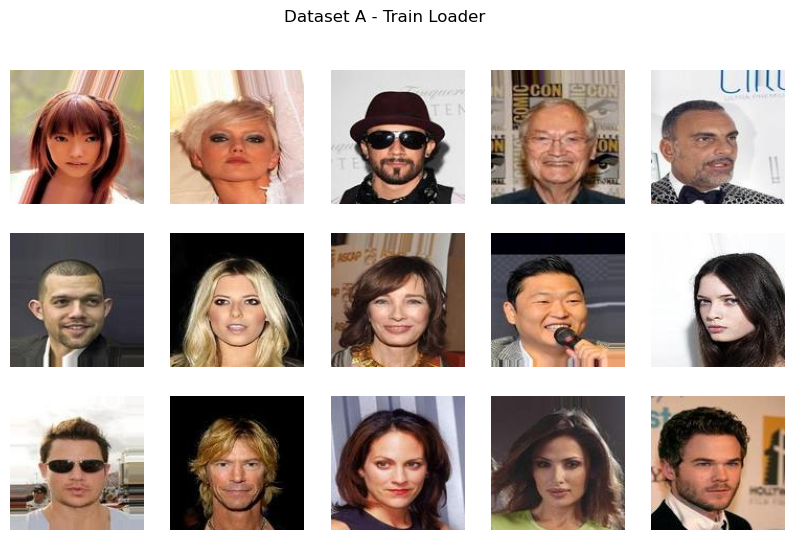

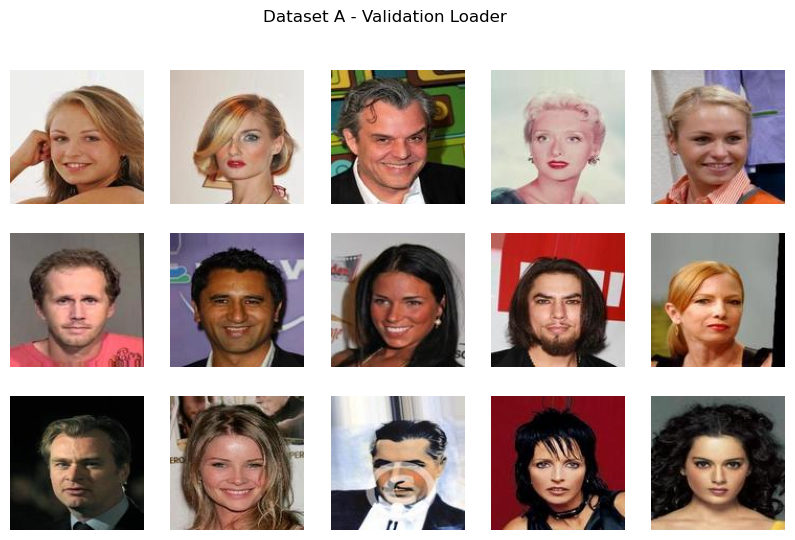

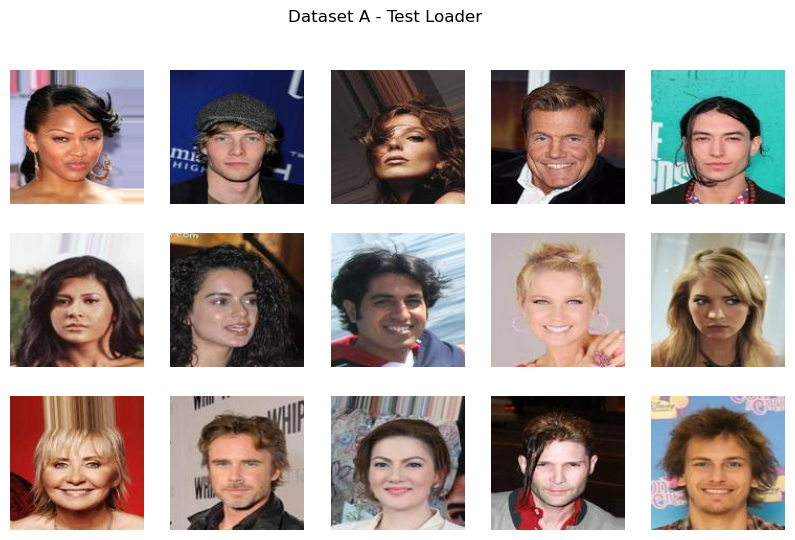

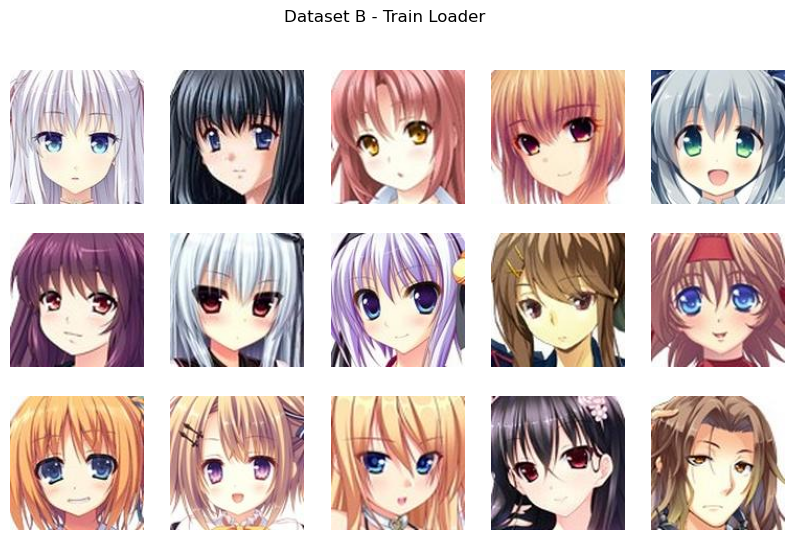

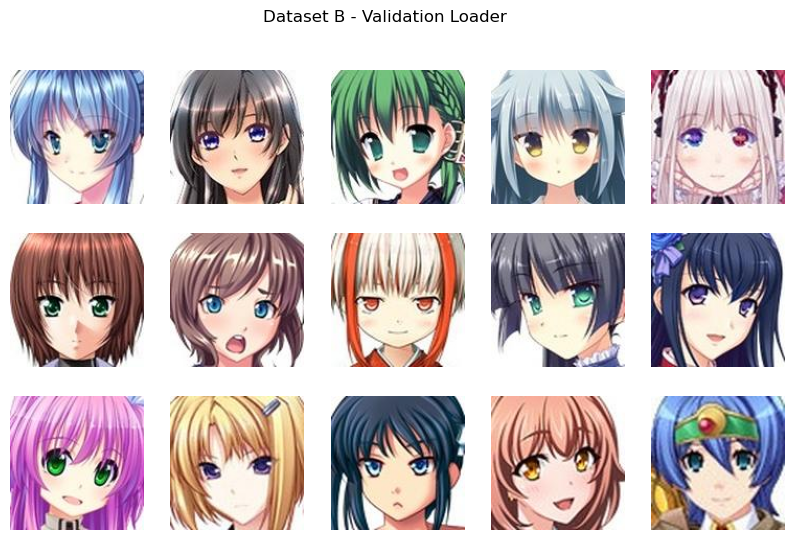

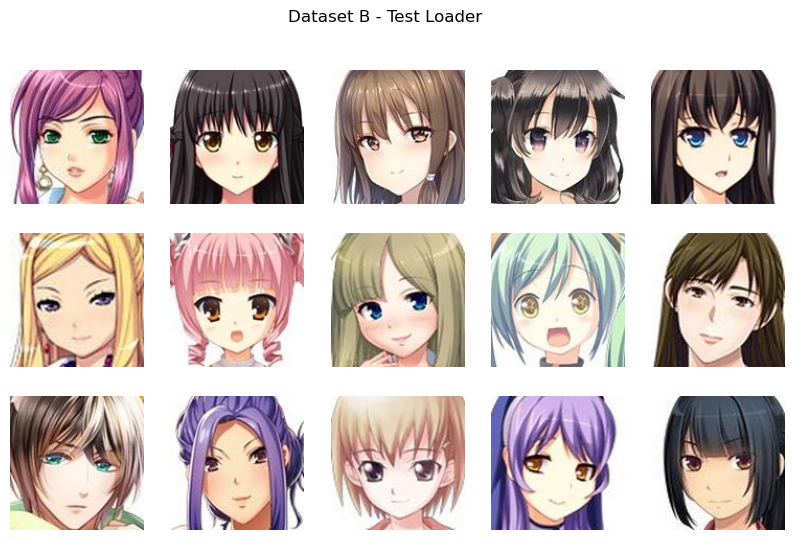

In [8]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=15):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

## Convolutional Block

In [9]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)


In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        """
        In a residual block, the use of two ConvBlock instances with one having 
        an activation function and the other not is a design choice that promotes 
        the learning of residual information.

        The purpose of a residual block is to learn the residual mapping between
        the input and output of the block. The first ConvBlock in the sequence, 
        which includes an activation function, helps in capturing and extracting 
        important features from the input. The activation function introduces 
        non-linearity, allowing the network to model complex relationships 
        between the input and output.

        The second ConvBlock does not include an activation function. 
        It mainly focuses on adjusting the dimensions (e.g., number of channels) 
        of the features extracted by the first ConvBlock. The absence of an 
        activation function in the second ConvBlock allows the block to learn 
        the residual information. By directly adding the output of the second 
        ConvBlock to the original input, the block learns to capture the 
        residual features or changes needed to reach the desired output.

        (Information and explanation above generated by ChatGPT)
        """
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, achieved through the addition operation, helps 
        in propagating gradients during training and alleviates the vanishing 
        gradient problem. It also facilitates the flow of information from earlier 
        layers to later layers, allowing the network to learn more effectively.

        (Information and explanation above generated by ChatGPT)
        """
        return x + self.block(x)

In [178]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer, 
        followed by 9 residual blocks for 128 × 128 training images 
        and then 3 upsampling/decoding layer. 
        
        The network with 6 residual blocks can be written as: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

        The network with 9 residual blocks consists of: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features, 
                    num_features * 2,
                    is_downsampling=True, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [179]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [180]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with 
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512. 
        
        After the last layer, we apply a convolution to produce a 1-dimensional 
        output. 
        
        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels, 
                    feature, 
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output 
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [190]:
import os
import numpy as np
import torch
from torchvision.utils import save_image
from tqdm import tqdm

def train_fn(disc_human, disc_anime, gen_anime, gen_human, train_loader_A, train_loader_B, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, num_epochs=1, start_epoch=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loss_anime_history = []
    train_loss_human_history = []
    val_loss_anime_history = []
    val_loss_human_history = []

    # Ensure the outputs directory exists
    os.makedirs('outputs', exist_ok=True)

    for epoch in range(num_epochs):
        current_epoch = start_epoch + epoch
        print(f"Epoch [{current_epoch + 1}/{start_epoch + num_epochs}]")
        epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")

        total_train_loss_anime = 0.0
        total_train_loss_human = 0.0
        total_batches = 0

        H_reals = 0
        H_fakes = 0

        for idx, ((human, _), (anime, _)) in enumerate(epoch_loop):
            human = human.to(device)
            anime = anime.to(device)

            # Train Discriminators Anime and Human
            with torch.cuda.amp.autocast():
                fake_anime = gen_anime(human)
                D_anime_real = disc_anime(anime)
                D_anime_fake = disc_anime(fake_anime.detach())
                H_reals += D_anime_real.mean().item()
                H_fakes += D_anime_fake.mean().item()
                anime_real_loss = mse(D_anime_real, torch.ones_like(D_anime_real))
                anime_fake_loss = mse(D_anime_fake, torch.zeros_like(D_anime_fake))
                D_anime_loss = anime_real_loss + anime_fake_loss

                fake_human = gen_human(anime)
                D_human_real = disc_human(human)
                D_human_fake = disc_human(fake_human.detach())
                human_real_loss = mse(D_human_real, torch.ones_like(D_human_real))
                human_fake_loss = mse(D_human_fake, torch.zeros_like(D_human_fake))
                D_human_loss = human_real_loss + human_fake_loss

                D_loss = (D_anime_loss + D_human_loss) / 2

            opt_disc.zero_grad()
            d_scaler.scale(D_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

            # Train Generators Anime and Human
            with torch.cuda.amp.autocast():
                # Adversarial losses
                D_anime_fake = disc_anime(fake_anime)
                D_human_fake = disc_human(fake_human)
                loss_G_anime = mse(D_anime_fake, torch.ones_like(D_anime_fake))
                loss_G_human = mse(D_human_fake, torch.ones_like(D_human_fake))

                # Cycle losses
                cycle_human = gen_human(fake_anime)
                cycle_anime = gen_anime(fake_human)
                cycle_human_loss = l1(human, cycle_human)
                cycle_anime_loss = l1(anime, cycle_anime)

                # Identity losses (optional)
                identity_human = gen_human(human)
                identity_anime = gen_anime(anime)
                identity_human_loss = l1(human, identity_human)
                identity_anime_loss = l1(anime, identity_anime)

                # Total loss
                G_loss = (
                    loss_G_anime
                    + loss_G_human
                    + cycle_human_loss * LAMBDA_CYCLE
                    + cycle_anime_loss * LAMBDA_CYCLE
                    + identity_anime_loss * LAMBDA_IDENTITY
                    + identity_human_loss * LAMBDA_IDENTITY
                )

            opt_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()

            # Save images more frequently
            if idx % 50 == 0:  # Save every 50 iterations
                save_image(fake_anime * 0.5 + 0.5, f"outputs/fake_anime_{epoch}_{idx}.png")
                save_image(fake_human * 0.5 + 0.5, f"outputs/fake_human_{epoch}_{idx}.png")
                save_image(human * 0.5 + 0.5, f"outputs/real_human_{epoch}_{idx}.png")
                save_image(anime * 0.5 + 0.5, f"outputs/real_anime_{epoch}_{idx}.png")

            # Update iteration progress bar
            epoch_loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item(), H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
            epoch_loop.update(1)

            # Accumulate training losses
            total_train_loss_anime += loss_G_anime.item()
            total_train_loss_human += loss_G_human.item()
            total_batches += 1

        epoch_loop.close()

        # Calculate average training losses
        avg_train_loss_anime = total_train_loss_anime / total_batches
        avg_train_loss_human = total_train_loss_human / total_batches

        # Evaluate models
        val_loss_anime = evaluate(gen_anime, disc_anime, val_loader_A, mse, device)
        val_loss_human = evaluate(gen_human, disc_human, val_loader_B, mse, device)
        
        # Print epoch summary
        print(f"Epoch {current_epoch + 1}: Train Loss Anime: {avg_train_loss_anime}, Train Loss Human: {avg_train_loss_human}, Validation Loss Anime: {val_loss_anime}, Validation Loss Human: {val_loss_human}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(gen_anime, opt_gen, filename=get_model_name("gen_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(gen_human, opt_gen, filename=get_model_name("gen_human", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_anime, opt_disc, filename=get_model_name("disc_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_human, opt_disc, filename=get_model_name("disc_human", current_epoch, LEARNING_RATE, BATCH_SIZE))

        print(f"Epoch {current_epoch + 1} checkpoint saved.")

        # Save training and validation losses
        train_loss_anime_history.append(avg_train_loss_anime)
        train_loss_human_history.append(avg_train_loss_human)
        val_loss_anime_history.append(val_loss_anime)
        val_loss_human_history.append(val_loss_human)


    save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, 
                get_model_name("loss", current_epoch, LEARNING_RATE, BATCH_SIZE))


In [10]:
import os
import shutil
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.cuda.amp import GradScaler

gen_anime = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_human = Generator(img_channels=3, num_residuals=9).to(DEVICE)
disc_anime = Discriminator(in_channels=3).to(DEVICE)
disc_human = Discriminator(in_channels=3).to(DEVICE)

opt_gen = optim.Adam(
    list(gen_anime.parameters()) + list(gen_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_disc = optim.Adam(
    list(disc_anime.parameters()) + list(disc_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

l1 = nn.L1Loss()
mse = nn.MSELoss()

d_scaler = GradScaler()
g_scaler = GradScaler()

NameError: name 'Generator' is not defined

In [183]:
# Example usage
list_checkpoints("models/gen_anime")
list_checkpoints("models/gen_human")
list_checkpoints("models/disc_anime")
list_checkpoints("models/disc_human")

No checkpoint found for prefix: models/gen_anime
No checkpoint found for prefix: models/gen_human
No checkpoint found for prefix: models/disc_anime
No checkpoint found for prefix: models/disc_human


In [186]:
if LOAD_MODEL:
        start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

=> No checkpoint found for models/gen_anime. Starting from scratch.
=> No checkpoint found for models/gen_human. Starting from scratch.
=> No checkpoint found for models/disc_anime. Starting from scratch.
=> No checkpoint found for models/disc_human. Starting from scratch.
Resuming from epoch 0


In [187]:
# if LOAD_MODEL:
#         start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         print(f"Resuming from epoch {start_epoch}")
# else:
#     start_epoch = 0
       
num_epochs = 50  # Total number of epochs to run
remaining_epochs = num_epochs - start_epoch
print(f"Starting training for {remaining_epochs} epochs from epoch {start_epoch + 1}")

 
train_fn(disc_human=disc_human, disc_anime=disc_anime, gen_anime=gen_anime, gen_human=gen_human, 
        train_loader_A=train_loader_A, train_loader_B=train_loader_B, 
        opt_disc=opt_disc, opt_gen=opt_gen, 
        l1=l1, mse=mse, d_scaler=d_scaler, g_scaler=g_scaler, 
        num_epochs=remaining_epochs, start_epoch=start_epoch)


Starting training for 50 epochs from epoch 1
Epoch [1/50]


Iteration: 100%|██████████| 219/219 [05:07<00:00,  1.40s/it, D_loss=0.0756, G_loss=12.9, H_fake=0.223, H_real=0.844]


Epoch 1: Train Loss Anime: 0.6799907771419716, Train Loss Human: 0.6745823250241476, Validation Loss Anime: 0.02619127293427785, Validation Loss Human: 0.023142545064290365
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_0.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_0.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_0.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_0.pth.tar
Epoch 1 checkpoint saved.
Epoch [2/50]


Iteration: 100%|██████████| 219/219 [05:12<00:00,  1.43s/it, D_loss=0.142, G_loss=6.2, H_fake=0.0574, H_real=0.959]  


Epoch 2: Train Loss Anime: 0.906353428755721, Train Loss Human: 0.711910445940549, Validation Loss Anime: 0.01995588465531667, Validation Loss Human: 0.025616860787073772
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_1.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_1.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_1.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_1.pth.tar
Epoch 2 checkpoint saved.
Epoch [3/50]


Iteration: 100%|██████████| 219/219 [03:37<00:00,  1.01it/s, D_loss=0.0329, G_loss=6.05, H_fake=0.0541, H_real=0.96] 


Epoch 3: Train Loss Anime: 0.9101552878884964, Train Loss Human: 0.8234472511565849, Validation Loss Anime: 0.02879562834898631, Validation Loss Human: 0.027767290751139324
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_2.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_2.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_2.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_2.pth.tar
Epoch 3 checkpoint saved.
Epoch [4/50]


Iteration: 100%|██████████| 219/219 [04:59<00:00,  1.37s/it, D_loss=0.0128, G_loss=5.47, H_fake=0.0445, H_real=0.964] 


Epoch 4: Train Loss Anime: 0.9314196101606709, Train Loss Human: 0.8819421347417787, Validation Loss Anime: 0.029464680274327595, Validation Loss Human: 0.0274431521097819
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_3.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_3.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_3.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_3.pth.tar
Epoch 4 checkpoint saved.
Epoch [5/50]


Iteration: 100%|██████████| 219/219 [04:33<00:00,  1.25s/it, D_loss=0.0283, G_loss=4.79, H_fake=0.0478, H_real=0.96]  


Epoch 5: Train Loss Anime: 0.9298266006386988, Train Loss Human: 0.9058736780462744, Validation Loss Anime: 0.02878291408220927, Validation Loss Human: 0.028845590194066364
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_4.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_4.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_4.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_4.pth.tar
Epoch 5 checkpoint saved.
Epoch [6/50]


Iteration: 100%|██████████| 219/219 [04:36<00:00,  1.26s/it, D_loss=0.00791, G_loss=5.01, H_fake=0.025, H_real=0.981] 


Epoch 6: Train Loss Anime: 0.959808934224795, Train Loss Human: 0.9355449341747859, Validation Loss Anime: 0.03014745513598124, Validation Loss Human: 0.028922608494758605
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_5.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_5.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_5.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_5.pth.tar
Epoch 6 checkpoint saved.
Epoch [7/50]


Iteration: 100%|██████████| 219/219 [04:28<00:00,  1.23s/it, D_loss=0.0236, G_loss=4.52, H_fake=0.0239, H_real=0.981] 


Epoch 7: Train Loss Anime: 0.9637612945412937, Train Loss Human: 0.9392460293421462, Validation Loss Anime: 0.027670336206754048, Validation Loss Human: 0.02731547216574351
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_6.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_6.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_6.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_6.pth.tar
Epoch 7 checkpoint saved.
Epoch [8/50]


Iteration: 100%|██████████| 219/219 [04:27<00:00,  1.22s/it, D_loss=0.00448, G_loss=4.29, H_fake=0.0126, H_real=0.991]


Epoch 8: Train Loss Anime: 0.9792042412714327, Train Loss Human: 0.9389148142239819, Validation Loss Anime: 0.03068422778447469, Validation Loss Human: 0.02872918438911438
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_7.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_7.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_7.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_7.pth.tar
Epoch 8 checkpoint saved.
Epoch [9/50]


Iteration: 100%|██████████| 219/219 [04:04<00:00,  1.12s/it, D_loss=0.00755, G_loss=4.33, H_fake=0.0247, H_real=0.978]


Epoch 9: Train Loss Anime: 0.966653067227368, Train Loss Human: 0.9537501392299181, Validation Loss Anime: 0.03011211641629537, Validation Loss Human: 0.030234071532885234
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_8.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_8.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_8.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_8.pth.tar
Epoch 9 checkpoint saved.
Epoch [10/50]


Iteration: 100%|██████████| 219/219 [04:13<00:00,  1.16s/it, D_loss=0.00515, G_loss=4.28, H_fake=0.0169, H_real=0.986]


Epoch 10: Train Loss Anime: 0.9737061346502609, Train Loss Human: 0.9689163549305642, Validation Loss Anime: 0.030994940360387167, Validation Loss Human: 0.030770034233729045
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_9.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_9.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_9.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_9.pth.tar
Epoch 10 checkpoint saved.
Epoch [11/50]


Iteration: 100%|██████████| 219/219 [04:04<00:00,  1.12s/it, D_loss=0.00111, G_loss=4, H_fake=0.011, H_real=0.992]     


Epoch 11: Train Loss Anime: 0.9820581587482261, Train Loss Human: 0.9779525856449179, Validation Loss Anime: 0.03082543178399404, Validation Loss Human: 0.030820465048154194
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_10.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_10.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_10.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_10.pth.tar
Epoch 11 checkpoint saved.
Epoch [12/50]


Iteration: 100%|██████████| 219/219 [04:03<00:00,  1.11s/it, D_loss=0.00773, G_loss=4.07, H_fake=0.0146, H_real=0.986]  


Epoch 12: Train Loss Anime: 0.9791723873517285, Train Loss Human: 0.9848152962449479, Validation Loss Anime: 0.02905917251110077, Validation Loss Human: 0.030912296692530313
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_11.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_11.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_11.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_11.pth.tar
Epoch 12 checkpoint saved.
Epoch [13/50]


Iteration: 100%|██████████| 219/219 [04:10<00:00,  1.14s/it, D_loss=0.000458, G_loss=4.05, H_fake=0.00921, H_real=0.994]


Epoch 13: Train Loss Anime: 0.9846316820954624, Train Loss Human: 0.9896038087535667, Validation Loss Anime: 0.031053541978200278, Validation Loss Human: 0.030779016653696697
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_12.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_12.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_12.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_12.pth.tar
Epoch 13 checkpoint saved.
Epoch [14/50]


Iteration: 100%|██████████| 219/219 [04:02<00:00,  1.11s/it, D_loss=0.0018, G_loss=3.9, H_fake=0.00561, H_real=0.996]   


Epoch 14: Train Loss Anime: 0.9904241665313233, Train Loss Human: 0.9918670880195757, Validation Loss Anime: 0.030969980835914613, Validation Loss Human: 0.0308851721684138
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_13.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_13.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_13.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_13.pth.tar
Epoch 14 checkpoint saved.
Epoch [15/50]


Iteration: 100%|██████████| 219/219 [04:03<00:00,  1.11s/it, D_loss=0.00425, G_loss=4.04, H_fake=0.00373, H_real=0.998] 


Epoch 15: Train Loss Anime: 0.9930466242032508, Train Loss Human: 0.9926591956452148, Validation Loss Anime: 0.031138809363047283, Validation Loss Human: 0.02931470310688019
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_14.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_14.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_14.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_14.pth.tar
Epoch 15 checkpoint saved.
Epoch [16/50]


Iteration: 100%|██████████| 219/219 [04:04<00:00,  1.12s/it, D_loss=0.00161, G_loss=4.11, H_fake=0.00271, H_real=0.998] 


Epoch 16: Train Loss Anime: 0.9949221273535462, Train Loss Human: 0.968651665944487, Validation Loss Anime: 0.031136702219645183, Validation Loss Human: 0.03085839335123698
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_15.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_15.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_15.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_15.pth.tar
Epoch 16 checkpoint saved.
Epoch [17/50]


Iteration: 100%|██████████| 219/219 [04:06<00:00,  1.12s/it, D_loss=0.000775, G_loss=3.81, H_fake=0.00248, H_real=0.998]


Epoch 17: Train Loss Anime: 0.9952359207688946, Train Loss Human: 0.9931962481916767, Validation Loss Anime: 0.03114264714717865, Validation Loss Human: 0.03117474897702535
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_16.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_16.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_16.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_16.pth.tar
Epoch 17 checkpoint saved.
Epoch [18/50]


Iteration: 100%|██████████| 219/219 [04:12<00:00,  1.15s/it, D_loss=3.34e-5, G_loss=3.63, H_fake=0.00215, H_real=0.999] 


Epoch 18: Train Loss Anime: 0.9958465523915748, Train Loss Human: 0.9956164800957458, Validation Loss Anime: 0.031219894409179688, Validation Loss Human: 0.031181040207544964
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_17.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_17.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_17.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_17.pth.tar
Epoch 18 checkpoint saved.
Epoch [19/50]


Iteration: 100%|██████████| 219/219 [04:10<00:00,  1.14s/it, D_loss=6.38e-5, G_loss=3.68, H_fake=0.00202, H_real=0.999] 


Epoch 19: Train Loss Anime: 0.9961681074747756, Train Loss Human: 0.9961864651610318, Validation Loss Anime: 0.031234329024950665, Validation Loss Human: 0.031220569570859273
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_18.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_18.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_18.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_18.pth.tar
Epoch 19 checkpoint saved.
Epoch [20/50]


Iteration: 100%|██████████| 219/219 [04:03<00:00,  1.11s/it, D_loss=9.24e-5, G_loss=3.56, H_fake=0.00188, H_real=0.999] 


Epoch 20: Train Loss Anime: 0.9964149447336589, Train Loss Human: 0.996503684890869, Validation Loss Anime: 0.031188913861910503, Validation Loss Human: 0.031172962506612143
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_19.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_19.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_19.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_19.pth.tar
Epoch 20 checkpoint saved.
Epoch [21/50]


Iteration: 100%|██████████| 219/219 [04:04<00:00,  1.11s/it, D_loss=2.6e-5, G_loss=3.81, H_fake=0.00159, H_real=0.999]  


Epoch 21: Train Loss Anime: 0.9969573069925177, Train Loss Human: 0.9968071999070851, Validation Loss Anime: 0.031191304047902425, Validation Loss Human: 0.031201990087827047
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_20.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_20.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_20.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_20.pth.tar
Epoch 21 checkpoint saved.
Epoch [22/50]


Iteration: 100%|██████████| 219/219 [03:51<00:00,  1.06s/it, D_loss=3.03e-5, G_loss=3.87, H_fake=0.00155, H_real=0.999] 


Epoch 22: Train Loss Anime: 0.9970538983606312, Train Loss Human: 0.9970387691232168, Validation Loss Anime: 0.031222052971522012, Validation Loss Human: 0.03122013024489085
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_21.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_21.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_21.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_21.pth.tar
Epoch 22 checkpoint saved.
Epoch [23/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=0.00316, G_loss=3.61, H_fake=0.0015, H_real=0.999]  


Epoch 23: Train Loss Anime: 0.9971549497347444, Train Loss Human: 0.9608063297728969, Validation Loss Anime: 0.031266685326894125, Validation Loss Human: 0.03017930777867635
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_22.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_22.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_22.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_22.pth.tar
Epoch 23 checkpoint saved.
Epoch [24/50]


Iteration: 100%|██████████| 219/219 [03:55<00:00,  1.07s/it, D_loss=0.0412, G_loss=3.59, H_fake=0.0286, H_real=0.972]   


Epoch 24: Train Loss Anime: 0.9661149156692366, Train Loss Human: 0.9863169209597862, Validation Loss Anime: 0.027255436937014262, Validation Loss Human: 0.0309995334148407
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_23.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_23.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_23.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_23.pth.tar
Epoch 24 checkpoint saved.
Epoch [25/50]


Iteration: 100%|██████████| 219/219 [03:43<00:00,  1.02s/it, D_loss=0.000309, G_loss=3.48, H_fake=0.0167, H_real=0.986]


Epoch 25: Train Loss Anime: 0.9760387090787496, Train Loss Human: 0.9904034932454427, Validation Loss Anime: 0.031053470532099406, Validation Loss Human: 0.03105218251546224
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_24.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_24.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_24.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_24.pth.tar
Epoch 25 checkpoint saved.
Epoch [26/50]


Iteration: 100%|██████████| 219/219 [03:46<00:00,  1.03s/it, D_loss=0.000179, G_loss=3.61, H_fake=0.00463, H_real=0.997]


Epoch 26: Train Loss Anime: 0.9918377358619481, Train Loss Human: 0.9948720782314806, Validation Loss Anime: 0.031153034845987956, Validation Loss Human: 0.031173045078913372
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_25.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_25.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_25.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_25.pth.tar
Epoch 26 checkpoint saved.
Epoch [27/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=0.00166, G_loss=3.56, H_fake=0.00241, H_real=0.999] 


Epoch 27: Train Loss Anime: 0.9954123058819879, Train Loss Human: 0.9953922828038534, Validation Loss Anime: 0.031206143021583557, Validation Loss Human: 0.030996692617734273
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_26.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_26.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_26.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_26.pth.tar
Epoch 27 checkpoint saved.
Epoch [28/50]


Iteration: 100%|██████████| 219/219 [03:42<00:00,  1.02s/it, D_loss=0.000207, G_loss=3.68, H_fake=0.00168, H_real=0.999]


Epoch 28: Train Loss Anime: 0.9967181592771451, Train Loss Human: 0.9740479161205902, Validation Loss Anime: 0.03124582827091217, Validation Loss Human: 0.030947713454564412
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_27.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_27.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_27.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_27.pth.tar
Epoch 28 checkpoint saved.
Epoch [29/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.02s/it, D_loss=0.000107, G_loss=3.56, H_fake=0.00144, H_real=0.999]


Epoch 29: Train Loss Anime: 0.9971965543211323, Train Loss Human: 0.9951353546691267, Validation Loss Anime: 0.031244258721669516, Validation Loss Human: 0.031148774067560833
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_28.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_28.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_28.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_28.pth.tar
Epoch 29 checkpoint saved.
Epoch [30/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=6.16e-5, G_loss=3.38, H_fake=0.0014, H_real=0.999]  


Epoch 30: Train Loss Anime: 0.9973022605730518, Train Loss Human: 0.996744742948715, Validation Loss Anime: 0.03126769860585531, Validation Loss Human: 0.031244420647621153
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_29.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_29.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_29.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_29.pth.tar
Epoch 30 checkpoint saved.
Epoch [31/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=1.91e-5, G_loss=3.47, H_fake=0.00131, H_real=0.999] 


Epoch 31: Train Loss Anime: 0.9974459575735815, Train Loss Human: 0.997395069087477, Validation Loss Anime: 0.03126409872372945, Validation Loss Human: 0.03121933682759603
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_30.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_30.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_30.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_30.pth.tar
Epoch 31 checkpoint saved.
Epoch [32/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=0.000295, G_loss=3.63, H_fake=0.00106, H_real=0.999]


Epoch 32: Train Loss Anime: 0.9979200159033684, Train Loss Human: 0.9828655779633892, Validation Loss Anime: 0.0312261198759079, Validation Loss Human: 0.030909929871559143
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_31.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_31.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_31.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_31.pth.tar
Epoch 32 checkpoint saved.
Epoch [33/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=8.03e-5, G_loss=3.3, H_fake=0.00105, H_real=0.999]  


Epoch 33: Train Loss Anime: 0.9979473847776787, Train Loss Human: 0.9958028766118228, Validation Loss Anime: 0.03126376267274221, Validation Loss Human: 0.031206336776415506
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_32.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_32.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_32.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_32.pth.tar
Epoch 33 checkpoint saved.
Epoch [34/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=2.56e-5, G_loss=3.46, H_fake=0.000993, H_real=0.999]


Epoch 34: Train Loss Anime: 0.9980486898117413, Train Loss Human: 0.9971445153837335, Validation Loss Anime: 0.03126971169312795, Validation Loss Human: 0.031236976345380148
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_33.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_33.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_33.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_33.pth.tar
Epoch 34 checkpoint saved.
Epoch [35/50]


Iteration: 100%|██████████| 219/219 [03:43<00:00,  1.02s/it, D_loss=5.26e-5, G_loss=3.38, H_fake=0.000935, H_real=0.999] 


Epoch 35: Train Loss Anime: 0.9981693924834195, Train Loss Human: 0.9978304987084375, Validation Loss Anime: 0.031259940703709924, Validation Loss Human: 0.03123809043566386
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_34.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_34.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_34.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_34.pth.tar
Epoch 35 checkpoint saved.
Epoch [36/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.02s/it, D_loss=5.29e-5, G_loss=3.33, H_fake=0.000889, H_real=0.999] 


Epoch 36: Train Loss Anime: 0.9982607198632472, Train Loss Human: 0.9980235864582672, Validation Loss Anime: 0.03127157803376516, Validation Loss Human: 0.031248172601064047
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_35.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_35.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_35.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_35.pth.tar
Epoch 36 checkpoint saved.
Epoch [37/50]


Iteration: 100%|██████████| 219/219 [03:37<00:00,  1.01it/s, D_loss=9e-6, G_loss=3.28, H_fake=0.000782, H_real=0.999]   


Epoch 37: Train Loss Anime: 0.9984570363340857, Train Loss Human: 0.9982706270261442, Validation Loss Anime: 0.0312786173025767, Validation Loss Human: 0.03126061169306437
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_36.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_36.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_36.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_36.pth.tar
Epoch 37 checkpoint saved.
Epoch [38/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.02s/it, D_loss=1.66e-5, G_loss=3.37, H_fake=0.000726, H_real=0.999] 


Epoch 38: Train Loss Anime: 0.9985691349800319, Train Loss Human: 0.998443443209069, Validation Loss Anime: 0.03127713934580485, Validation Loss Human: 0.03127047808965047
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_37.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_37.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_37.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_37.pth.tar
Epoch 38 checkpoint saved.
Epoch [39/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=0.00452, G_loss=4.01, H_fake=0.000854, H_real=0.999] 


Epoch 39: Train Loss Anime: 0.9983688350681845, Train Loss Human: 0.9829013804866843, Validation Loss Anime: 0.031293190121650695, Validation Loss Human: 0.030640902042388916
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_38.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_38.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_38.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_38.pth.tar
Epoch 39 checkpoint saved.
Epoch [40/50]


Iteration: 100%|██████████| 219/219 [03:43<00:00,  1.02s/it, D_loss=0.0011, G_loss=3.32, H_fake=0.000558, H_real=1]      


Epoch 40: Train Loss Anime: 0.9988989938884021, Train Loss Human: 0.9904319486117255, Validation Loss Anime: 0.031283592303593954, Validation Loss Human: 0.0311971671183904
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_39.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_39.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_39.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_39.pth.tar
Epoch 40 checkpoint saved.
Epoch [41/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=0.000174, G_loss=3.27, H_fake=0.000601, H_real=1]


Epoch 41: Train Loss Anime: 0.998817403839059, Train Loss Human: 0.9961690238621681, Validation Loss Anime: 0.03126787539323171, Validation Loss Human: 0.031183245023091635
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_40.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_40.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_40.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_40.pth.tar
Epoch 41 checkpoint saved.
Epoch [42/50]


Iteration: 100%|██████████| 219/219 [03:45<00:00,  1.03s/it, D_loss=9.7e-6, G_loss=3.54, H_fake=0.000613, H_real=1]      


Epoch 42: Train Loss Anime: 0.998804313679264, Train Loss Human: 0.9978305893401577, Validation Loss Anime: 0.03130158380667369, Validation Loss Human: 0.03128460681438446
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_41.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_41.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_41.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_41.pth.tar
Epoch 42 checkpoint saved.
Epoch [43/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=8.17e-5, G_loss=3.19, H_fake=0.000554, H_real=1] 


Epoch 43: Train Loss Anime: 0.998907045686626, Train Loss Human: 0.9982236555722206, Validation Loss Anime: 0.03129800367355347, Validation Loss Human: 0.031198232491811115
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_42.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_42.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_42.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_42.pth.tar
Epoch 43 checkpoint saved.
Epoch [44/50]


Iteration: 100%|██████████| 219/219 [03:41<00:00,  1.01s/it, D_loss=1.79e-5, G_loss=3.17, H_fake=0.000538, H_real=1] 


Epoch 44: Train Loss Anime: 0.9989419299173573, Train Loss Human: 0.9980532295627681, Validation Loss Anime: 0.03129513176282247, Validation Loss Human: 0.031250709493954976
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_43.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_43.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_43.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_43.pth.tar
Epoch 44 checkpoint saved.
Epoch [45/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=1.27e-5, G_loss=3.44, H_fake=0.000499, H_real=1] 


Epoch 45: Train Loss Anime: 0.9990170821207299, Train Loss Human: 0.9984153645223679, Validation Loss Anime: 0.03130582098166148, Validation Loss Human: 0.031285176356633505
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_44.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_44.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_44.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_44.pth.tar
Epoch 45 checkpoint saved.
Epoch [46/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, D_loss=2.26e-5, G_loss=3.37, H_fake=0.000493, H_real=1]


Epoch 46: Train Loss Anime: 0.9990306189071098, Train Loss Human: 0.9985255081903989, Validation Loss Anime: 0.031304497917493186, Validation Loss Human: 0.03127832897504171
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_45.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_45.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_45.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_45.pth.tar
Epoch 46 checkpoint saved.
Epoch [47/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.02s/it, D_loss=8.89e-6, G_loss=3.16, H_fake=0.000429, H_real=1]


Epoch 47: Train Loss Anime: 0.999155125933695, Train Loss Human: 0.9985513703463829, Validation Loss Anime: 0.03130524492263794, Validation Loss Human: 0.03127245958646138
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_46.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_46.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_46.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_46.pth.tar
Epoch 47 checkpoint saved.
Epoch [48/50]


Iteration: 100%|██████████| 219/219 [03:44<00:00,  1.02s/it, D_loss=7.58e-6, G_loss=3.23, H_fake=0.00039, H_real=1] 


Epoch 48: Train Loss Anime: 0.9992293778075475, Train Loss Human: 0.9986590922695316, Validation Loss Anime: 0.03130807820955912, Validation Loss Human: 0.031283794283866885
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_47.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_47.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_47.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_47.pth.tar
Epoch 48 checkpoint saved.
Epoch [49/50]


Iteration: 100%|██████████| 219/219 [03:48<00:00,  1.04s/it, D_loss=0.245, G_loss=2.77, H_fake=0.00898, H_real=0.993]


Epoch 49: Train Loss Anime: 0.9879979892680634, Train Loss Human: 0.9988399656940269, Validation Loss Anime: 0.016801468074321747, Validation Loss Human: 0.03128285292784373
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_48.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_48.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_48.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_48.pth.tar
Epoch 49 checkpoint saved.
Epoch [50/50]


Iteration: 100%|██████████| 219/219 [03:47<00:00,  1.04s/it, D_loss=0.000189, G_loss=3.46, H_fake=0.0258, H_real=0.978]


Epoch 50: Train Loss Anime: 0.9700420901655606, Train Loss Human: 0.9746916345809693, Validation Loss Anime: 0.031134788473447163, Validation Loss Human: 0.0310146773258845
=> Saving checkpoint to models/gen_anime_lr0.0002_bs32_epoch_49.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs32_epoch_49.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs32_epoch_49.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs32_epoch_49.pth.tar
Epoch 50 checkpoint saved.


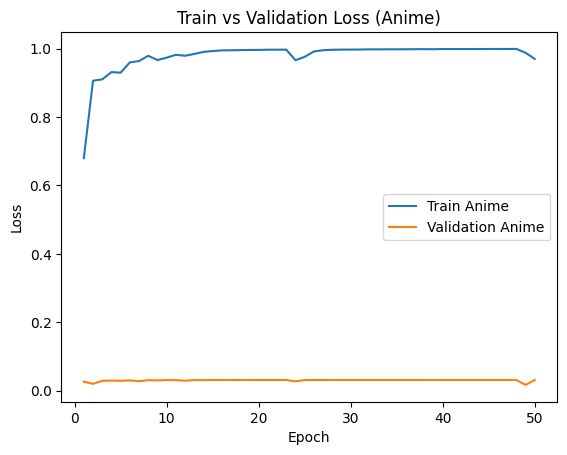

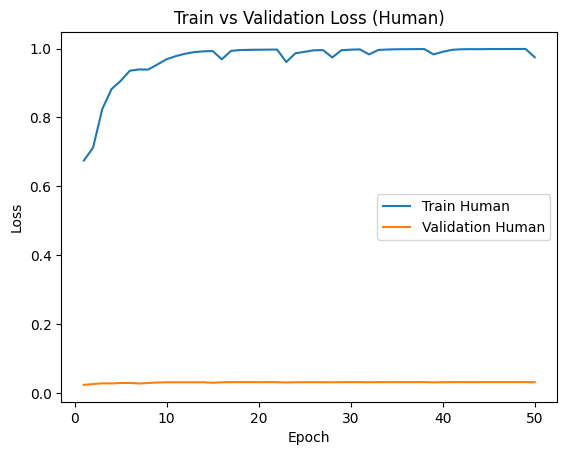

In [189]:
gan_model_path = get_model_name("loss", epoch=49, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
plot_training_curve(gan_model_path)